# Time Series Forecasting

## Extraction

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('data/conv_data.csv')
df

,timestamp,hourly average,usage,hour,day_of_week
0,2024-02-01 00:00:00,1.955991e+07,0.000000,0,3
1,2024-02-01 01:00:00,1.956011e+07,0.199500,1,3
2,2024-02-01 02:00:00,1.956033e+07,0.220500,2,3
3,2024-02-01 03:00:00,1.956056e+07,0.225000,3,3
4,2024-02-01 04:00:00,1.956076e+07,0.204500,4,3
...,...,...,...,...,...
4472,2024-08-28 09:00:00,4.186957e+07,13.110667,9,2
4473,2024-08-28 10:00:00,4.189131e+07,21.741000,10,2
4474,2024-08-28 11:00:00,4.190912e+07,17.805583,11,2
4475,2024-08-28 12:00:00,4.192575e+07,16.629350,12,2


In [3]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [4]:
missing_values = df.isnull().sum()
missing_values


hourly average    0
usage             0
hour              0
day_of_week       0
dtype: int64

In [5]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['week'] = df.index.isocalendar().week
df['weekday'] = df.index.weekday  # 0 for Monday, 6 for Sunday
df['hour'] = df.index.hour

In [6]:
df

,hourly average,usage,hour,day_of_week,year,month,day,week,weekday
timestamp,,,,,,,,,
2024-02-01 00:00:00,1.955991e+07,0.000000,0,3,2024,2,1,5,3
2024-02-01 01:00:00,1.956011e+07,0.199500,1,3,2024,2,1,5,3
2024-02-01 02:00:00,1.956033e+07,0.220500,2,3,2024,2,1,5,3
2024-02-01 03:00:00,1.956056e+07,0.225000,3,3,2024,2,1,5,3
2024-02-01 04:00:00,1.956076e+07,0.204500,4,3,2024,2,1,5,3
...,...,...,...,...,...,...,...,...,...
2024-08-28 09:00:00,4.186957e+07,13.110667,9,2,2024,8,28,35,2
2024-08-28 10:00:00,4.189131e+07,21.741000,10,2,2024,8,28,35,2
2024-08-28 11:00:00,4.190912e+07,17.805583,11,2,2024,8,28,35,2


## EDA

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

Overall Usage

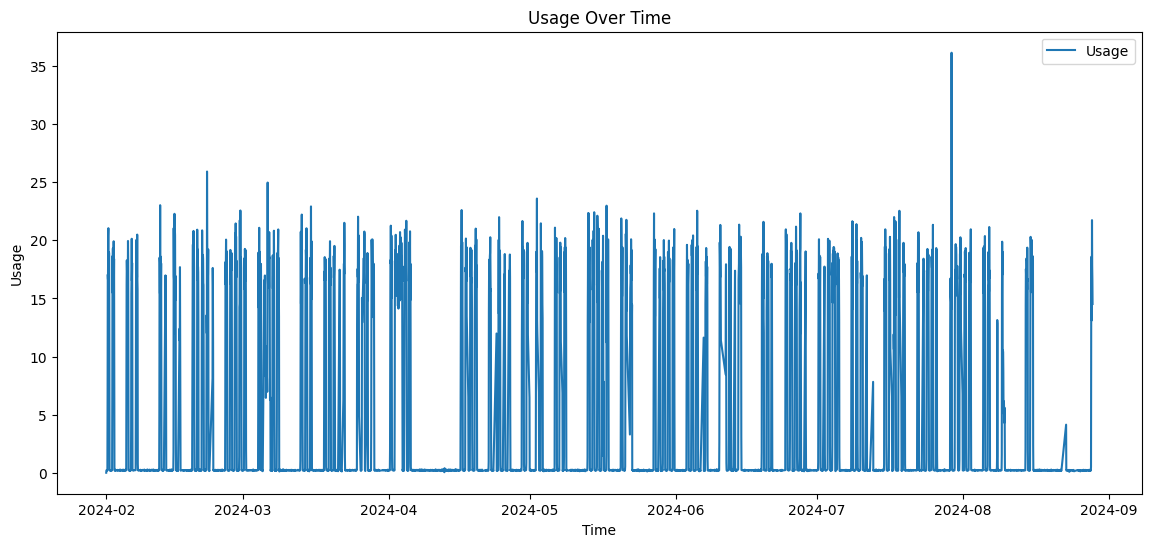

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['usage'], label='Usage')
plt.title('Usage Over Time')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.legend()
plt.show()

Daily Patterns

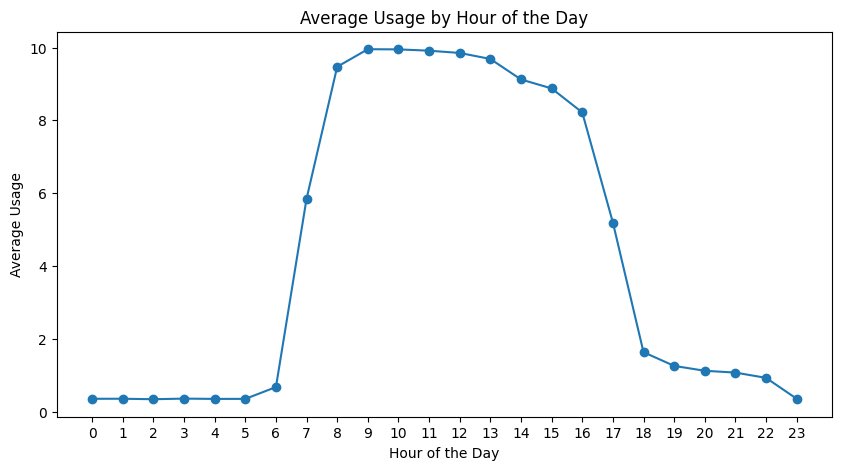

In [9]:
hourly_usage = df.groupby('hour')['usage'].mean()
plt.figure(figsize=(10, 5))
plt.plot(hourly_usage, marker='o')
plt.title('Average Usage by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Usage')
plt.xticks(range(0, 24))
plt.show()

Weekly Pattern

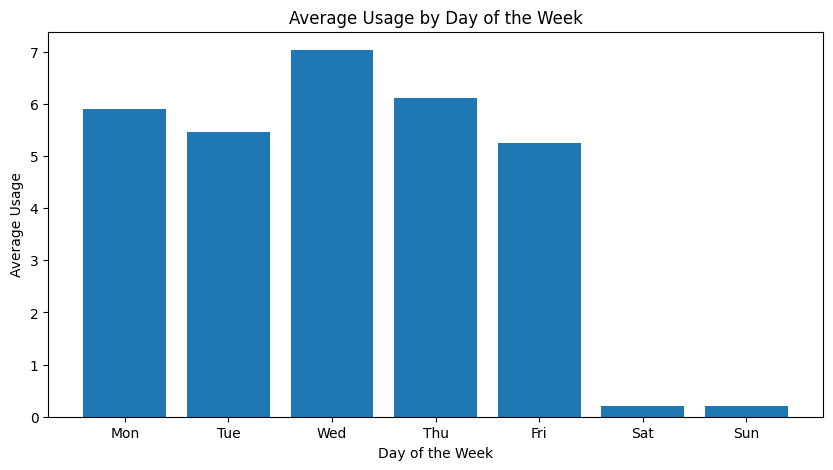

In [10]:
weekday_usage = df.groupby('weekday')['usage'].mean()
plt.figure(figsize=(10, 5))
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], weekday_usage)
plt.title('Average Usage by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Usage')
plt.show()

Monthly Pattern

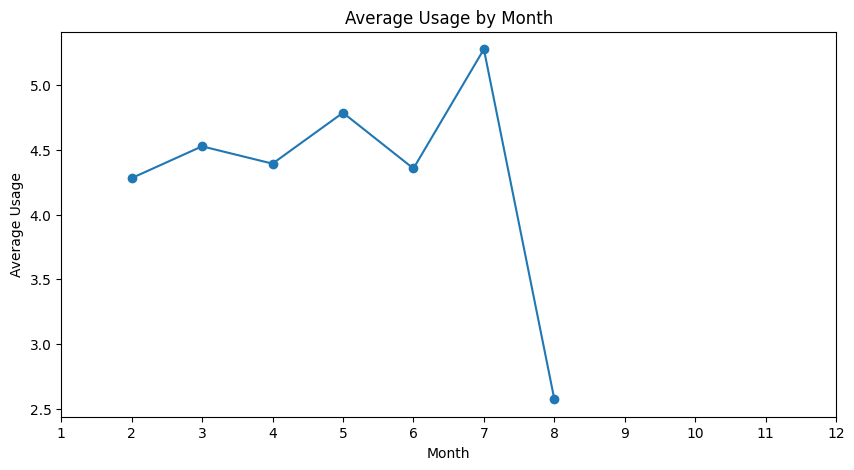

In [11]:
monthly_usage = df.groupby('month')['usage'].mean()
plt.figure(figsize=(10, 5))
plt.plot(monthly_usage, marker='o')
plt.title('Average Usage by Month')
plt.xlabel('Month')
plt.ylabel('Average Usage')
plt.xticks(range(1, 13))
plt.show()

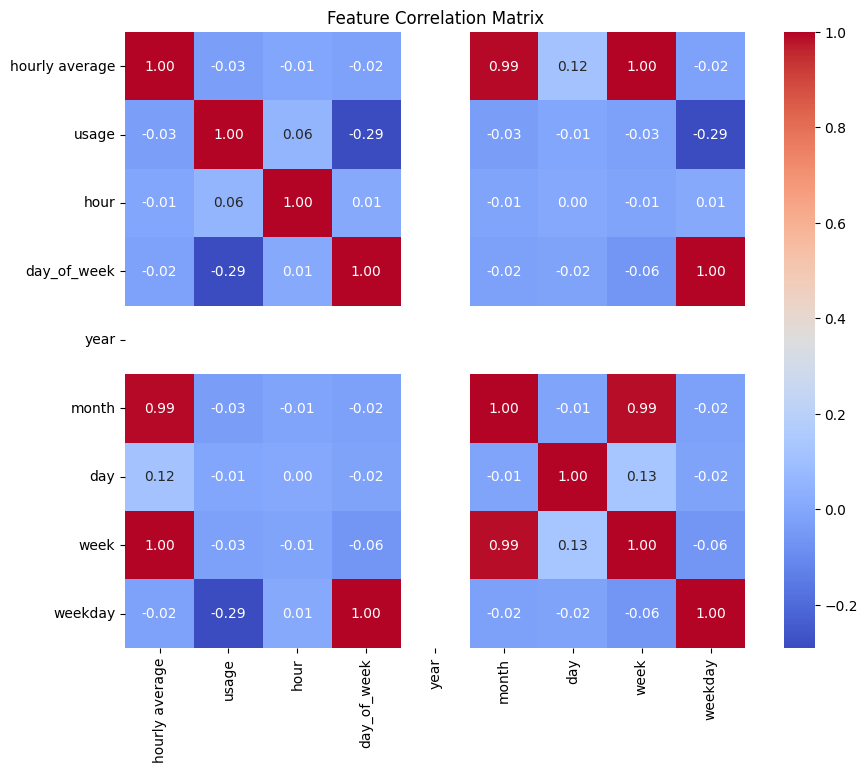

In [12]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

Stationarity check

In [13]:
from statsmodels.tsa.stattools import adfuller

In [15]:
adf_test = adfuller(df['usage'])
adf_statistic = adf_test[0]
p_value = adf_test[1]

adf_statistic, p_value

(-9.713554084220005, 9.967368002682916e-17)

Since the p-value is significantly less than 0.05, we can reject the null hypothesis and conclude that the data is stationary. Thus, the data is suitable for modeling

## Modelling (LSTM)

In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
df['usage_normalized'] = scaler.fit_transform(df[['usage']])

In [18]:
time_steps = 24

In [19]:
X = []
y = []

for i in range(time_steps, len(df)):
    X.append(df['usage_normalized'].iloc[i - time_steps:i].values)
    y.append(df['usage_normalized'].iloc[i])

In [20]:
X = np.array(X)
y = np.array(y)

X.shape, y.shape

((4453, 24), (4453,))

In [ ]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=250, return_sequences=True), input_shape=(X.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=100, return_sequences=False)))
model.add(tf.keras.layers.Dropout(0.2))

# Adding the output layer
model.add(tf.keras.layers.Dense(units=1, activation='relu'))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

C:\Users\62813\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 24, 500)        │       504,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 500)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200)            │       480,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           201 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 985,001 (3.76 MB)

 Trainable params: 985,001 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - loss: 0.0230 - mean_absolute_error: 0.0949 - val_loss: 0.0089 - val_mean_absolute_error: 0.0651
Epoch 2/50
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 65ms/step - loss: 0.0102 - mean_absolute_error: 0.0575 - val_loss: 0.0074 - val_mean_absolute_error: 0.0353
Epoch 3/50
 10/112 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.0091 - mean_absolute_error: 0.0549

KeyboardInterrupt: 

## Evaluate

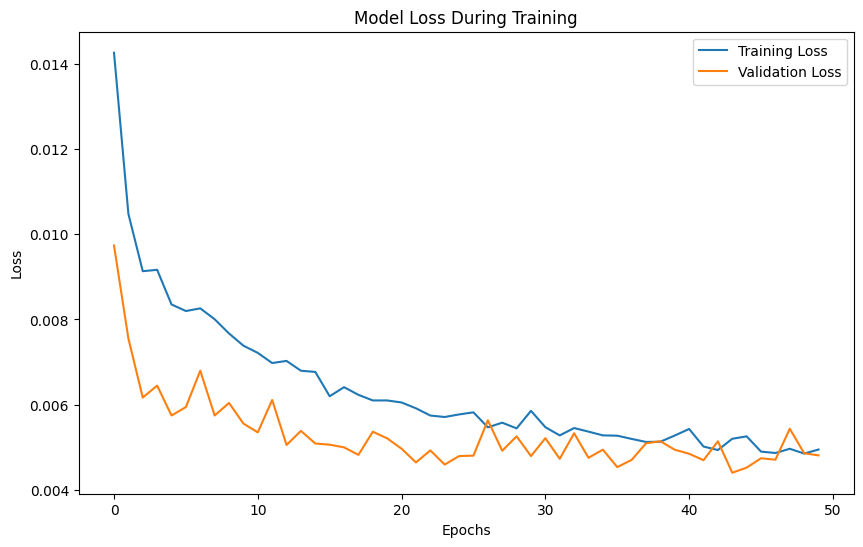

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X)

y_pred_original = scaler.inverse_transform(y_pred)
y_original = scaler.inverse_transform(y.reshape(-1, 1))

140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [ ]:
mae = np.mean(np.abs(y_original - y_pred_original))
mse = np.mean((y_original - y_pred_original) ** 2)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 1.1030824282550382
Mean Squared Error (MSE): 6.105963042337358
Root Mean Squared Error (RMSE): 2.4710246948052457


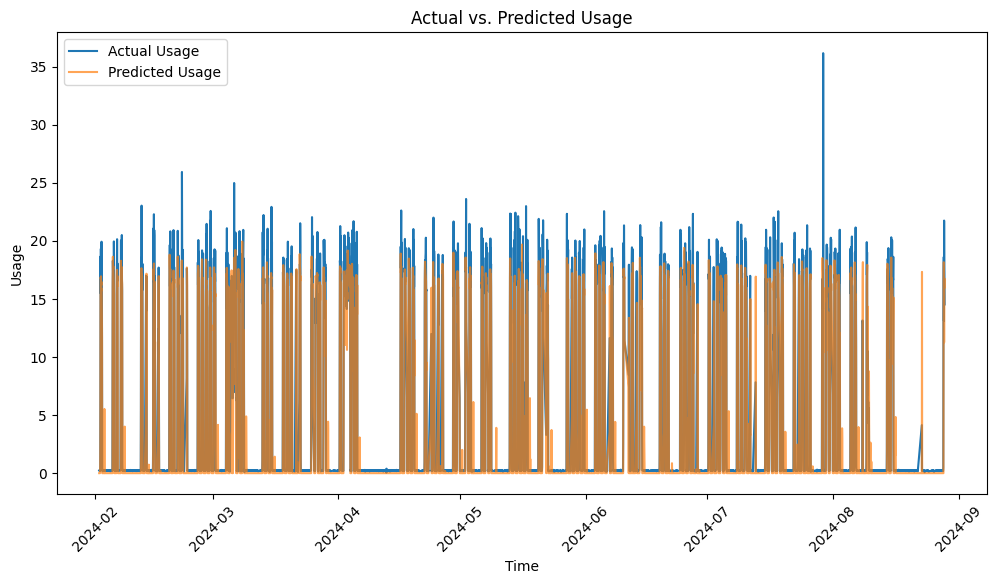

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[time_steps:], y_original, label='Actual Usage')
plt.plot(df.index[time_steps:], y_pred_original, label='Predicted Usage', alpha=0.7)
plt.title('Actual vs. Predicted Usage')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.xticks(rotation=45)  
plt.legend()
plt.show()

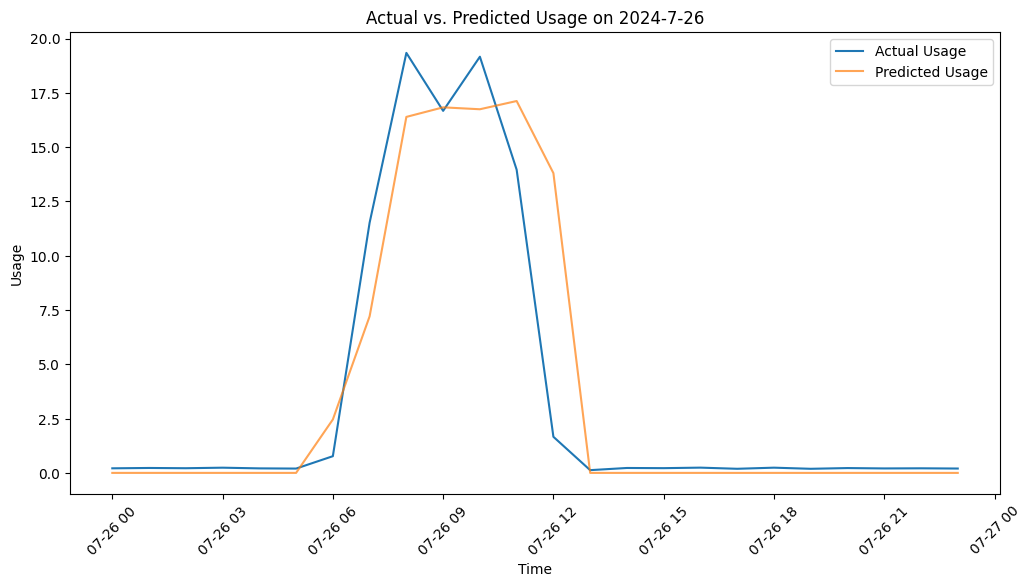

In [ ]:
specific_date = '2024-7-26'

timestamps = df.index[time_steps:]
mask = (timestamps >= specific_date) & (timestamps < specific_date + ' 23:59:59')

y_original_specific_day = y_original[mask]
y_pred_specific_day = y_pred_original[mask]
timestamps_specific_day = timestamps[mask]

# Plotting actual vs. predicted usage for the specific day
plt.figure(figsize=(12, 6))
plt.plot(timestamps_specific_day, y_original_specific_day, label='Actual Usage')
plt.plot(timestamps_specific_day, y_pred_specific_day, label='Predicted Usage', alpha=0.7)
plt.title(f'Actual vs. Predicted Usage on {specific_date}')
plt.xlabel('Time')
plt.ylabel('Usage')
plt.xticks(rotation=45)
plt.legend()
plt.show()